In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
AWCI = yf.download(tickers = 'EWA EWZ EWC FXI EWQ EWG EWH EWI EWJ EWY EWN EWS EZA EWP EWD EWL EWT EWU IVV',
                        start="2009-01-01", end="2013-12-31") #previous 5 years
table1 = AWCI['Adj Close']
table1.head()

[*********************100%***********************]  19 of 19 completed


,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWL,EWN,EWP,EWQ,EWS,EWT,EWU,EWY,EWZ,EZA,FXI,IVV
Date,,,,,,,,,,,,,,,,,,,
2008-12-31,8.359440,13.756172,10.482170,14.790632,7.322011,23.506798,31.910786,14.335720,11.570380,22.598188,15.425570,9.200068,11.526129,15.764547,23.781942,25.045715,24.761438,22.145769,71.273544
2009-01-02,8.448941,14.111321,10.967208,14.875281,7.618563,23.721930,32.077351,14.297056,11.919354,22.884926,15.794071,9.461061,11.845035,15.828895,24.674728,26.269726,25.378387,23.683571,73.601692
2009-01-05,8.335573,14.537502,10.650584,14.505900,7.604442,23.492462,31.277905,14.010966,11.709969,22.640003,15.410832,9.669859,11.769104,16.214966,24.734247,27.257517,25.294846,23.950010,73.412285
2009-01-06,8.598114,14.900547,10.839210,14.552073,7.759779,23.707596,30.978106,14.065090,11.834050,22.765453,15.469791,9.630708,11.890592,16.613901,25.312428,28.810797,25.847528,24.026144,73.877922
2009-01-07,8.263972,14.300735,10.812263,14.336599,7.569138,23.764963,30.678328,13.980032,11.756498,22.490669,15.278169,9.226167,11.617244,16.112013,25.312428,27.100040,24.343718,22.305643,71.707603


In [3]:
#AWCI plus IGV, which perfomance well in hw1. IGV == iShares Expanded Tech-Software Sector ETF
portfolio = yf.download(tickers = 'EWA EWZ EWC FXI EWQ EWG EWH EWI EWJ EWY EWN EWS EZA EWP EWD EWL EWT EWU IVV IGV',
                        start="2009-01-01", end="2013-12-31")
table2 = portfolio['Adj Close']
table2.head()

[*********************100%***********************]  20 of 20 completed


,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWL,EWN,EWP,EWQ,EWS,EWT,EWU,EWY,EWZ,EZA,FXI,IGV,IVV
Date,,,,,,,,,,,,,,,,,,,,
2008-12-31,8.359440,13.756172,10.482170,14.790632,7.322011,23.506798,31.910786,14.335720,11.570380,22.598188,15.425570,9.200068,11.526129,15.764547,23.781942,25.045715,24.761438,22.145769,30.839142,71.273544
2009-01-02,8.448941,14.111321,10.967208,14.875281,7.618563,23.721930,32.077351,14.297056,11.919354,22.884926,15.794071,9.461061,11.845035,15.828895,24.674728,26.269726,25.378387,23.683571,32.120472,73.601692
2009-01-05,8.335573,14.537502,10.650584,14.505900,7.604442,23.492462,31.277905,14.010966,11.709969,22.640003,15.410832,9.669859,11.769104,16.214966,24.734247,27.257517,25.294846,23.950010,31.829254,73.412285
2009-01-06,8.598114,14.900547,10.839210,14.552073,7.759779,23.707596,30.978106,14.065090,11.834050,22.765453,15.469791,9.630708,11.890592,16.613901,25.312428,28.810797,25.847528,24.026144,32.440807,73.877922
2009-01-07,8.263972,14.300735,10.812263,14.336599,7.569138,23.764963,30.678328,13.980032,11.756498,22.490669,15.278169,9.226167,11.617244,16.112013,25.312428,27.100040,24.343718,22.305643,31.499220,71.707603


In [4]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns)) #len(mean_returns) == Number of ETFs
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [5]:
#AWCI
returns1 = table1.pct_change()
mean_returns1 = returns1.mean()
cov_matrix1 = returns1.cov()
#AWCI plus IGV
returns2 = table2.pct_change()
mean_returns2 = returns2.mean()
cov_matrix2 = returns2.cov()
num_portfolios = 25000 #stimulate for 25000 times
risk_free_rate = 0.0231 #2019/05/01 rate

In [6]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.19
Annualised Volatility: 0.24


             EWA   EWC    EWD  EWG    EWH   EWI   EWJ   EWL   EWN   EWP   EWQ  \
allocation  3.84  1.97  11.15  4.1  10.95  0.41  0.31  6.41  0.25  2.02  4.89   

             EWS   EWT    EWU  EWY   EWZ   EZA   FXI   IVV  
allocation  10.7  9.47  10.01  5.6  0.54  6.91  0.97  9.51  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.17
Annualised Volatility: 0.23


             EWA  EWC   EWD   EWG    EWH   EWI    EWJ   EWL   EWN   EWP   EWQ  \
allocation  6.88  0.5  4.59  3.78  10.45  0.48  12.42  9.24  2.88  0.62  6.57   

             EWS    EWT   EWU   EWY   EWZ   EZA   FXI    IVV  
allocation  8.25  10.12  0.98  2.05  3.03  3.65  2.48  11.02  


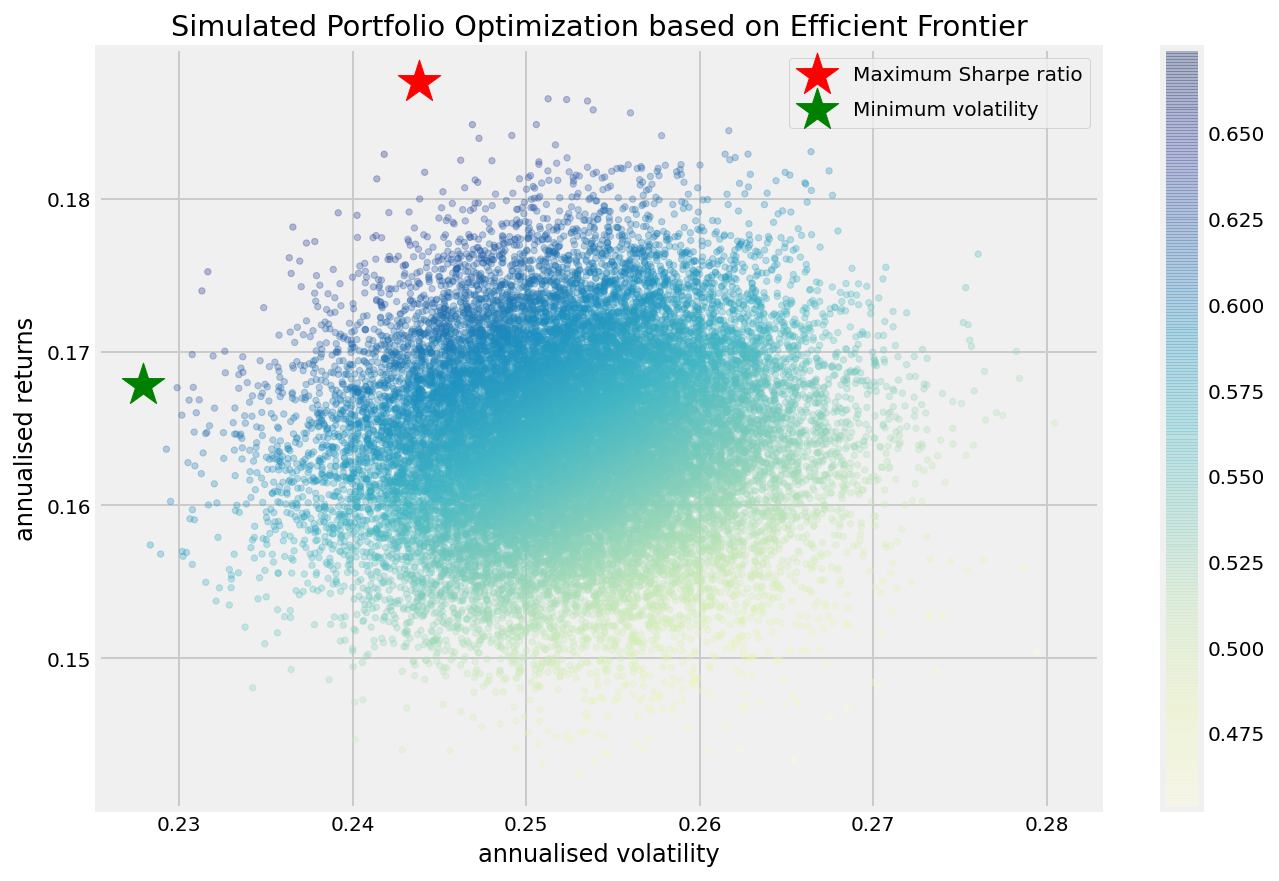

In [7]:
#efficient frontier of AWCI
table = table1
display_simulated_ef_with_random(mean_returns1, cov_matrix1, num_portfolios, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.19
Annualised Volatility: 0.24


             EWA   EWC    EWD   EWG   EWH   EWI   EWJ    EWL   EWN   EWP  \
allocation  6.41  0.57  12.84  3.02  3.21  1.38  1.03  10.92  0.58  0.04   

             EWQ   EWS   EWT    EWU   EWY  EWZ   EZA  FXI    IGV    IVV  
allocation  0.12  1.61  8.79  12.38  9.33  4.1  1.78  0.4  11.32  10.18  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.17
Annualised Volatility: 0.22


            EWA   EWC  EWD   EWG   EWH   EWI   EWJ    EWL   EWN  EWP   EWQ  \
allocation  2.7  7.84  0.3  2.09  3.77  0.71  6.06  11.67  9.92  1.2  0.35   

              EWS   EWT  EWU   EWY   EWZ   EZA   FXI   IGV   IVV  
allocation  10.51  9.52  0.5  6.38  1.22  0.96  5.38  11.1  7.82  


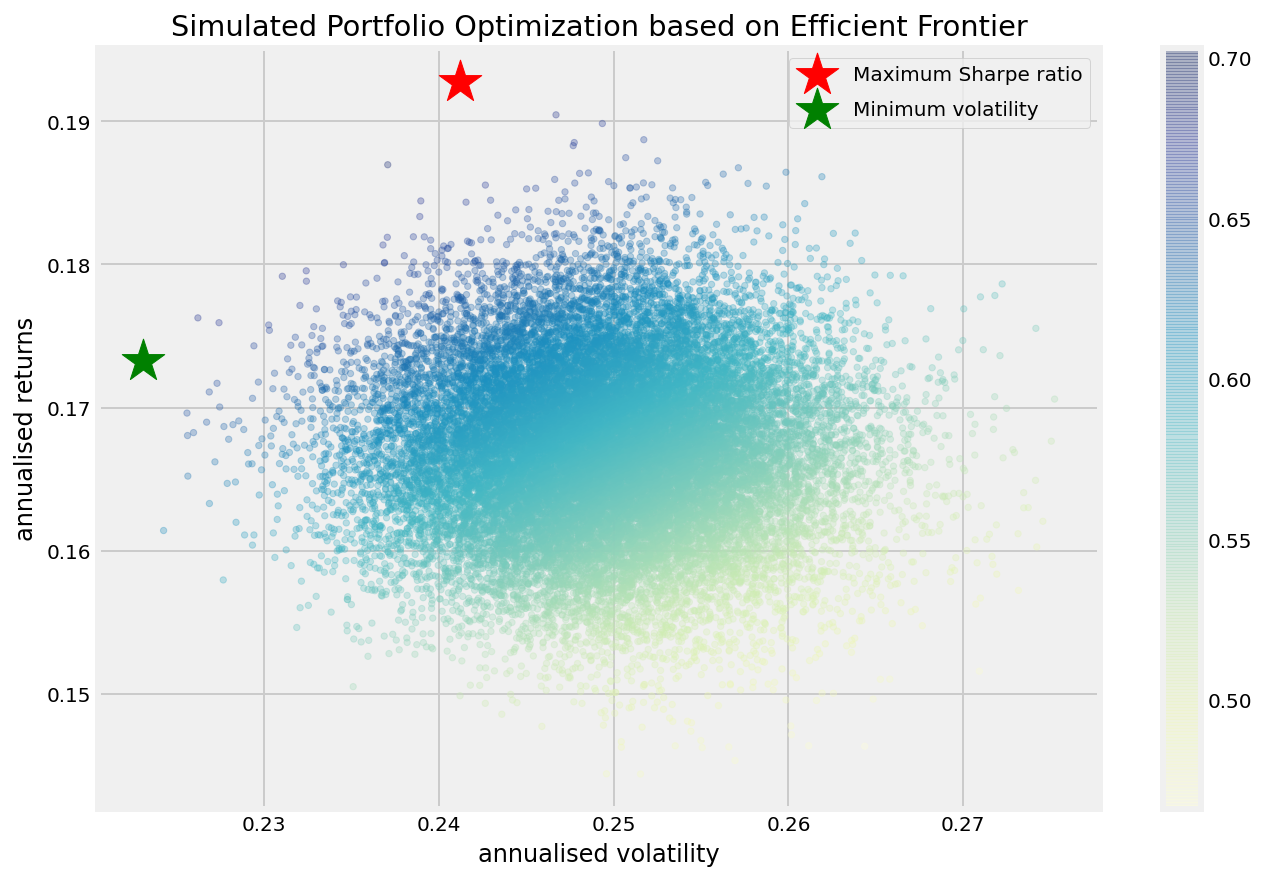

In [8]:
#efficient frontier of AWCI plus IGV, which is better (more return with same volatility, 0.08/0.15>0.06/0.14)
table = table2
display_simulated_ef_with_random(mean_returns2, cov_matrix2, num_portfolios, risk_free_rate)

In [9]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [10]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [11]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [12]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.22, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.2
Annualised Volatility: 0.21


            EWA  EWC  EWD  EWG    EWH  EWI  EWJ  EWL  EWN  EWP  EWQ  EWS  EWT  \
allocation  0.0  0.0  0.0  0.0  21.78  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            EWU  EWY  EWZ  EZA  FXI   IGV    IVV  
allocation  0.0  0.0  0.0  0.0  0.0  54.5  23.72  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.19


            EWA  EWC  EWD  EWG   EWH  EWI   EWJ   EWL  EWN  EWP  EWQ  EWS  \
allocation  0.0  0.0  0.0  0.0  4.58  0.0  34.2  2.86  0.0  0.0  0.0  0.0   

            EWT  EWU  EWY  EWZ  EZA  FXI  IGV    IVV  
allocation  0.0  0.0  0.0  0.0  0.0  0.0  0.0  58.36  
--------------------------------------------------------------------------------
Individual Stock Returns and Volatil

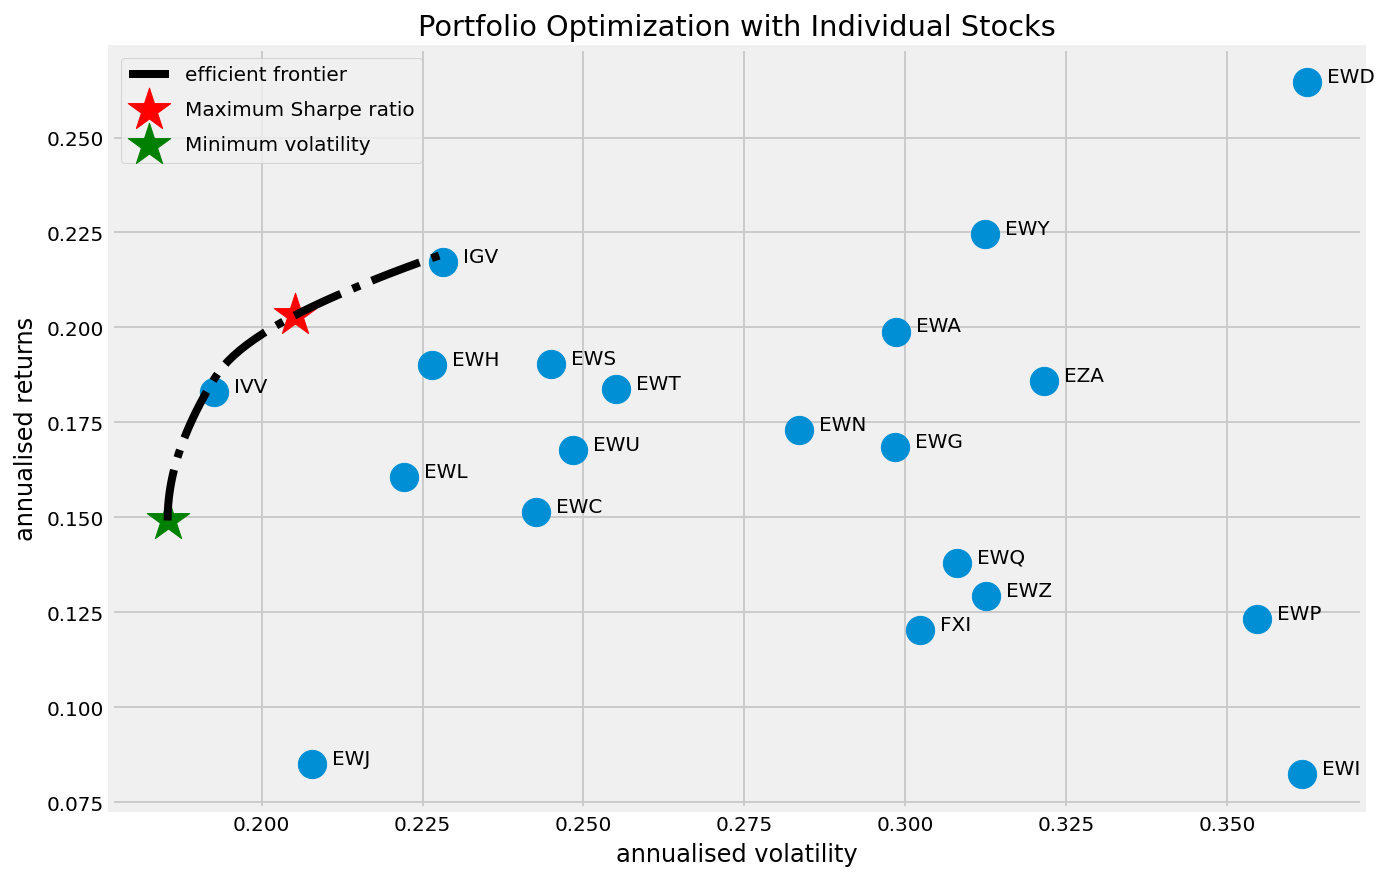

In [13]:
returns = returns2
display_ef_with_selected(mean_returns2, cov_matrix2, risk_free_rate)

In [14]:
import statistics
import math

In [15]:
#AWCI old
oldAWCI = yf.download(tickers = 'EWA EWZ EWC FXI EWQ EWG EWH EWI EWJ EWY EWN EWS EZA EWP EWD EWL EWT EWU IVV',
                        start="2014-01-01", end="2019-04-30") #Split to two phase 20050101~20131231, 20140101~20190430
old = oldAWCI['Adj Close']
#AWCI new (Replace IVV with IGV)
newAWCI = yf.download(tickers = 'EWA EWZ EWC FXI EWQ EWG EWH EWI EWJ EWY EWN EWS EZA EWP EWD EWL EWT EWU IGV',
                        start="2014-01-01", end="2019-04-30") #Split to two phase 20050101~20131231, 20140101~20190430
new = newAWCI['Adj Close']

[*********************100%***********************]  19 of 19 completed
[*********************100%***********************]  19 of 19 completed


In [16]:
weights = np.array([0.01797,0.00554,0.02888,0.04935,0.02994,0.0239,0.01081,0.00598,0.0751,0.01466,0.01201,0.00316,0.00454,0.00672,0.00773,0.03099,0.0154,0.04248,0.61484])

In [17]:
#Calculate the return of AWCI
i = 0 #2013/12/31
returns = old.pct_change()
date = []
AWCI_return = []
all_AWCI_return = []
while(i<len(old)):
    #Calculate return everyday
    date.append(old.index[i])
    if i==0:
        AWCI_return.append(100)
    else:
        daily_return = returns['EWA'][i]*weights[0]+returns['EWZ'][i]*weights[1]+returns['EWC'][i]*weights[2]+returns['FXI'][i]*weights[3]+returns['EWQ'][i]*weights[4]+returns['EWG'][i]*weights[5]+returns['EWH'][i]*weights[6]+returns['EWI'][i]*weights[7]+returns['EWJ'][i]*weights[8]+returns['EWY'][i]*weights[9]+returns['EWN'][i]*weights[10]+returns['EWS'][i]*weights[11]+returns['EZA'][i]*weights[12]+returns['EWP'][i]*weights[13]+returns['EWD'][i]*weights[14]+returns['EWL'][i]*weights[15]+returns['EWT'][i]*weights[16]+returns['EWU'][i]*weights[17]+returns['IVV'][i]*weights[18]
        all_AWCI_return.append(daily_return)
        temp = AWCI_return[i-1]*(1+daily_return)
        AWCI_return.append(temp)
    i += 1

In [18]:
#Calculate the return of new asset pool
i = 0 #2013/12/31
returns = new.pct_change()
date = []
newAWCI_return = []
all_newAWCI_return = []
while(i<len(new)):
    #Calculate return everyday
    date.append(new.index[i])
    if i==0:
        newAWCI_return.append(100)
    else:
        daily_return = returns['EWA'][i]*weights[0]+returns['EWZ'][i]*weights[1]+returns['EWC'][i]*weights[2]+returns['FXI'][i]*weights[3]+returns['EWQ'][i]*weights[4]+returns['EWG'][i]*weights[5]+returns['EWH'][i]*weights[6]+returns['EWI'][i]*weights[7]+returns['EWJ'][i]*weights[8]+returns['EWY'][i]*weights[9]+returns['EWN'][i]*weights[10]+returns['EWS'][i]*weights[11]+returns['EZA'][i]*weights[12]+returns['EWP'][i]*weights[13]+returns['EWD'][i]*weights[14]+returns['EWL'][i]*weights[15]+returns['EWT'][i]*weights[16]+returns['EWU'][i]*weights[17]+returns['IGV'][i]*weights[18]
        all_newAWCI_return.append(daily_return)
        temp = newAWCI_return[i-1]*(1+daily_return)
        newAWCI_return.append(temp)
    i += 1

Text(0, 0.5, 'Accumulate return')

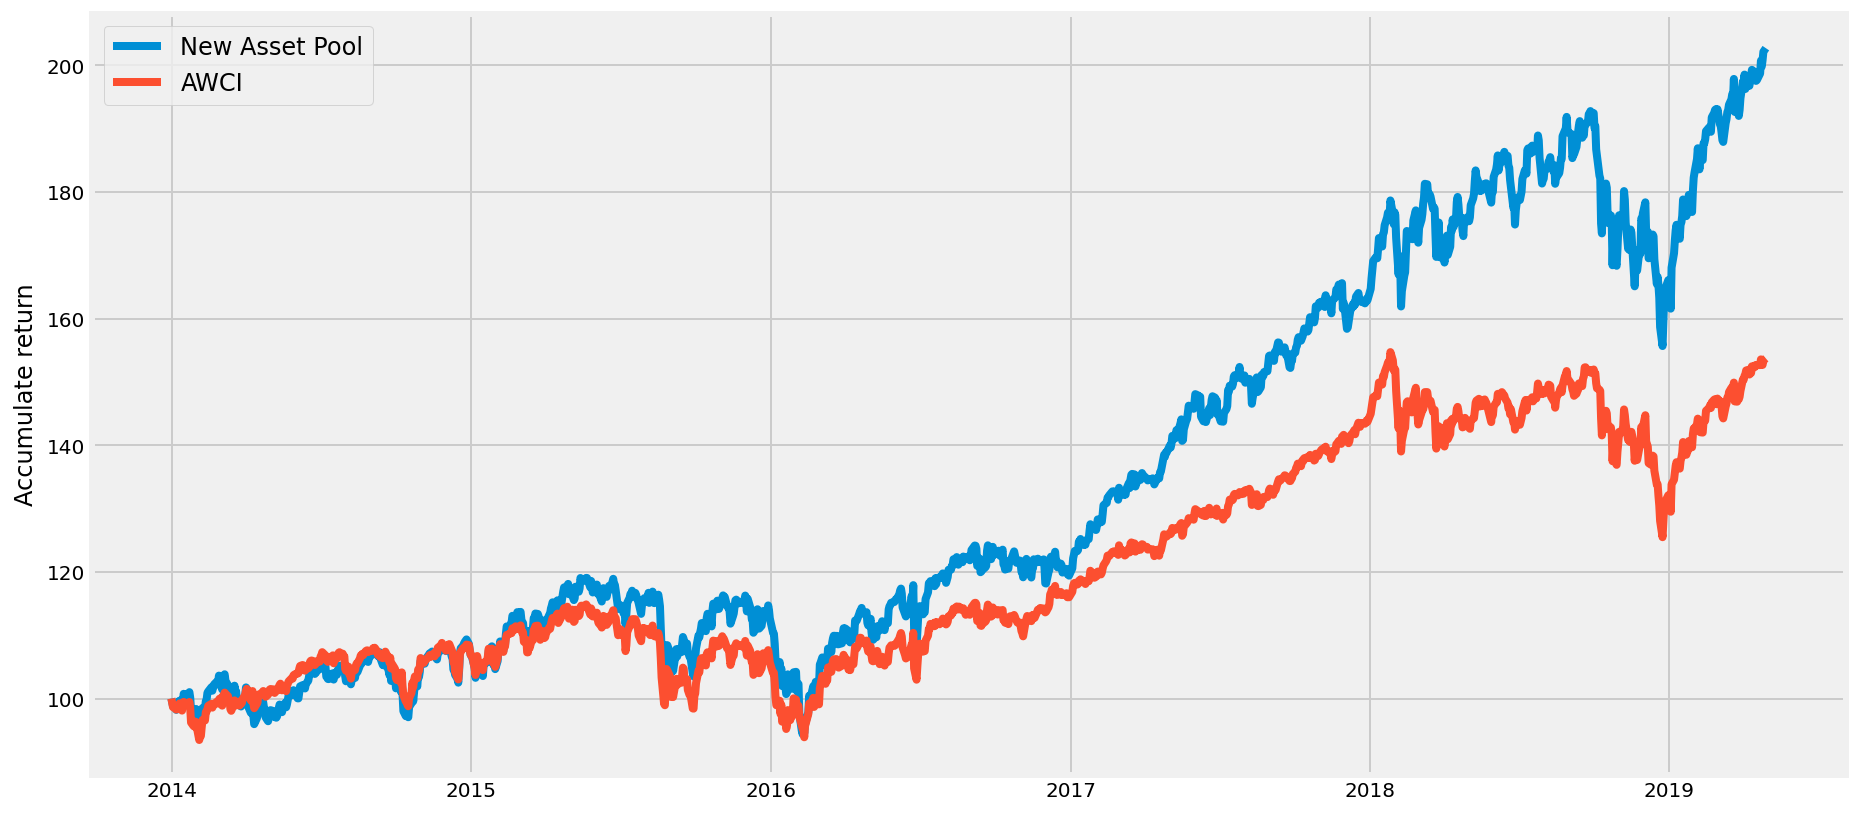

In [19]:
plt.figure(figsize=(14, 7))
plt.plot(date,newAWCI_return,label='New Asset Pool')
plt.plot(date,AWCI_return,label='AWCI')
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Accumulate return')

In [20]:
#Annual Return
print(math.pow(newAWCI_return[len(newAWCI_return)-1]/100,3/16))
print(math.pow(AWCI_return[len(AWCI_return)-1]/100,3/16))
#Annual Volatility
print(statistics.stdev(all_newAWCI_return)*np.sqrt(252))
print(statistics.stdev(all_AWCI_return)*np.sqrt(252))
#Return/ Risk
print((math.pow(newAWCI_return[len(newAWCI_return)-1]/100,3/16)-1)/(statistics.stdev(all_newAWCI_return)*np.sqrt(252)))
print((math.pow(AWCI_return[len(AWCI_return)-1]/100,3/16)-1)/(statistics.stdev(all_AWCI_return)*np.sqrt(252)))

1.1416586751072764
1.083945339284022
0.1604112540524881
0.1314299474248175
0.8830968621498607
0.6387078510553432


In [21]:
#The training part of asset pool, AWCI plus IGV
trainphase = yf.download(tickers = 'EWA EWZ EWC FXI EWQ EWG EWH EWI EWJ EWY EWN EWS EZA EWP EWD EWL EWT EWU IGV',
                        start="2004-12-01", end="2013-12-31") #Split to two phase 20050101~20131231, 20140101~20190430
train = trainphase['Adj Close']
train.head()

[*********************100%***********************]  19 of 19 completed


,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWL,EWN,EWP,EWQ,EWS,EWT,EWU,EWY,EWZ,EZA,FXI,IGV
Date,,,,,,,,,,,,,,,,,,,
2004-11-30,7.896676,12.762678,12.637380,12.478574,7.431767,29.409536,33.034912,12.215910,12.011512,17.818510,15.468410,7.672673,14.795859,19.303463,23.083195,13.156436,21.870142,13.283204,38.977554
2004-12-01,7.910921,12.799629,12.655308,12.780537,7.567339,29.926540,33.483498,12.245328,12.192994,17.929216,15.686834,7.898654,14.874701,19.749098,23.442589,13.314190,21.997082,13.440318,40.055443
2004-12-02,7.953657,12.600097,12.715057,12.773512,7.573501,29.577856,33.611656,12.215910,12.179554,17.955580,15.660362,7.909417,15.058667,19.727358,23.442589,13.169057,21.774239,13.449836,40.151695
2004-12-03,8.015384,12.614877,12.691159,12.899912,7.555014,30.118917,33.707779,12.355647,12.253488,18.134813,15.739788,7.801806,14.992960,19.825182,23.320066,13.415152,21.926559,13.426033,40.758007
2004-12-06,7.929916,12.577924,12.643357,12.899912,7.530367,30.251177,33.355328,12.179136,12.266933,18.176987,15.693452,7.801806,15.242628,19.803440,23.197542,13.440387,21.593704,13.423653,40.950489


In [22]:
#train long short portfolio (3 view)
i = 23 #2004/12/31
ticker = ['EWA','EWZ','EWC','FXI','EWQ','EWG','EWH','EWI','EWJ','EWY','EWN','EWS','EZA','EWP','EWD','EWL','EWT','EWU','IGV']
nextMonth = 1
#long short portfolio attributes
Q1 = []
Q2 = []
Q3 = []
while(i<len(train)-20): #-20 to make sure we can see Q's answer
    #Calculate view's Q in every month's first trading day
    if train.index.month[i]==nextMonth:
        if nextMonth==12:
            nextMonth = 1
        else:
            nextMonth += 1
        #bband (%B) ,Bias and RSI
        pb = [] #%B
        bias = []
        rsi = []
        for t in ticker:
            #bband (%B) and Bias
            price = train[t][i-20:i].copy().values.tolist()
            twentyMA = statistics.mean(price)
            bandwidth = statistics.stdev(price)*2
            pb.append((train[t][i]-(twentyMA-bandwidth))/(bandwidth*2))
            bias.append((train[t][i]-twentyMA)/twentyMA)
            #RSI
            up = []
            down = []
            k=0
            while(k<len(price)):
                if k>0:
                    change = price[k]-price[k-1]
                    if change>0:
                        up.append(change)
                    else:
                        down.append(change)
                k += 1
            rsi.append(statistics.mean(up)*100/(statistics.mean(up)+statistics.mean(down)))
        pb = np.array(pb)
        bias = np.array(bias)
        rsi = np.array(rsi)
        #produce view
        future_price = np.array(train[i+1:i+21].copy()) #future 20 day's price as answer
        #view 1's Q
        temp1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        temp2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(pb)[-1:]: #Max 3, relative near upperband
            temp1[j] = 1
        for j in np.argsort(pb)[:1]: #min 3, relative near lowerband
            temp2[j] = 1
        temp1 = np.array(temp1)
        temp2 = np.array(temp2)
        Q1.append(np.dot(temp1.T,future_price[19])/np.dot(temp1.T,future_price[0]) - np.dot(temp2.T,future_price[19])/np.dot(temp2.T,future_price[0]))
        #view 2's Q
        temp1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        temp2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(bias)[-1:]: #Max 2, big chance to drop
            temp1[j] = 1
        for j in np.argsort(bias)[:2]: #min 2, big chance to rise
            temp2[j] = 0.5
        temp1 = np.array(temp1)
        temp2 = np.array(temp2)
        Q2.append(np.dot(temp1.T,future_price[19])/np.dot(temp1.T,future_price[0]) - np.dot(temp2.T,future_price[19])/np.dot(temp2.T,future_price[0])) 
        #view 3's Q
        temp1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        temp2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(rsi)[-4:]: #Max 4, rise more in past 20 days
            temp1[j] = 0.25
        for j in np.argsort(rsi)[:4]: #min 4, rise less in past 20 days
            temp2[j] = 0.25
        temp1 = np.array(temp1)
        temp2 = np.array(temp2)
        Q3.append(np.dot(temp1.T,future_price[19])/np.dot(temp1.T,future_price[0]) - np.dot(temp2.T,future_price[19])/np.dot(temp2.T,future_price[0]))
    i += 1
#mean return
Q = np.array([statistics.mean(Q1),statistics.mean(Q2),statistics.mean(Q3)])
Q *= np.sqrt(252)/np.sqrt(20) #Annualize
#variance covariance
all_record = []
all_record.append(pd.DataFrame(Q1))
all_record.append(pd.DataFrame(Q2))
all_record.append(pd.DataFrame(Q3))
all_record = pd.concat(all_record,axis=1)
omega = all_record.cov() #use as inverse matirx of omega later
print(Q)
print(omega)

[0.04267838 0.02920541 0.00407435]
          0         0         0
0  0.002830  0.000891  0.000205
0  0.000891  0.001754  0.000009
0  0.000205  0.000009  0.000936


In [23]:
#The testing part of asset pool, AWCI plus IGV
testphase = yf.download(tickers = 'EWA EWZ EWC FXI EWQ EWG EWH EWI EWJ EWY EWN EWS EZA EWP EWD EWL EWT EWU IGV',
                        start="2014-01-01", end="2019-04-30") #Split to two phase 20050101~20131231, 20140101~20190430
test = testphase['Adj Close']
test.head()

[*********************100%***********************]  19 of 19 completed


,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWL,EWN,EWP,EWQ,EWS,EWT,EWU,EWY,EWZ,EZA,FXI,IGV
Date,,,,,,,,,,,,,,,,,,,
2013-12-31,18.104282,25.395220,28.323757,27.490726,16.734818,25.670000,43.858120,28.248270,22.550507,30.618099,24.303427,20.646404,24.621490,31.322546,57.811623,37.654293,48.560165,32.486462,80.201500
2014-01-02,17.963131,25.221043,27.588591,26.616489,16.556095,25.241892,43.135582,27.580379,22.193945,29.752834,23.722540,20.317190,23.989731,30.932514,55.102962,36.398586,46.685238,31.428129,79.703102
2014-01-03,18.141424,25.203623,27.564875,26.529934,16.328632,25.324219,43.388470,27.854383,22.159153,29.641689,23.620024,20.176102,23.904360,30.947514,54.763260,36.600842,46.572285,31.038673,79.722656
2014-01-06,18.081993,25.038153,27.556969,26.659767,16.353001,25.554739,43.243961,27.845823,22.141764,30.062429,23.602940,20.035009,23.631166,30.872515,54.325226,36.171047,46.368984,30.488335,79.175377
2014-01-07,18.052279,24.942352,27.730879,26.754982,16.482981,25.900522,43.424599,27.871513,22.280909,30.935642,23.773792,20.066360,23.784836,30.992514,54.530838,36.171047,46.737946,30.496807,80.318764


In [24]:
returns = test.pct_change()
#Original AWCI weight, Replace IVV with IGV
weights = np.array([0.01797,0.00554,0.02888,0.04935,0.02994,0.0239,0.01081,0.00598,0.0751,0.01466,0.01201,0.00316,0.00454,0.00672,0.00773,0.03099,0.0154,0.04248,0.61484])
origin_weights = weights.copy()
#Assumptions
tau = 0.05
risk_aversion = 3.37

In [25]:
#Calculate Black-Litterman return (3 view)
i = 0 #2013/12/31
ticker = ['EWA','EWZ','EWC','FXI','EWQ','EWG','EWH','EWI','EWJ','EWY','EWN','EWS','EZA','EWP','EWD','EWL','EWT','EWU','IGV']
nextRebalanceMonth = 2
date = []
test_return = []
all_test_return = []
while(i<len(test)):
    #balance with view every month
    if test.index.month[i]==nextRebalanceMonth:
        if nextRebalanceMonth==12:
            nextRebalanceMonth = 1
        else:
            nextRebalanceMonth += 1
        #Reset weights to origin one
        weights = origin_weights.copy()
        #bband (%B) ,Bias and RSI
        pb = [] #%B
        bias = []
        rsi = []
        for t in ticker:
            #bband (%B) and Bias
            price = test[t][i-20:i].copy().values.tolist()
            twentyMA = statistics.mean(price)
            bandwidth = statistics.stdev(price)*2
            pb.append((test[t][i]-(twentyMA-bandwidth))/(bandwidth*2))
            bias.append((test[t][i]-twentyMA)/twentyMA)
            #RSI
            up = []
            down = []
            k=0
            while(k<len(price)):
                if k>0:
                    change = price[k]-price[k-1]
                    if change>0:
                        up.append(change)
                    else:
                        down.append(change)
                k += 1
            rsi.append(statistics.mean(up)*100/(statistics.mean(up)+statistics.mean(down)))
        pb = np.array(pb)
        bias = np.array(bias)
        rsi = np.array(rsi)
        #produce view
        sigma = returns[i-20:i].copy().cov()
        implied_excess_return = risk_aversion*np.dot(sigma, weights)
        #view 1
        P1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(pb)[-1:]: #Max 1, relative near upperband
            P1[j] = 1
        for j in np.argsort(pb)[:1]: #min 1, relative near lowerband
            P1[j] = -1
        #view 2
        P2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(bias)[-1:]: #Max 1, big chance to drop
            P2[j] = 1
        for j in np.argsort(bias)[:2]: #min 2, big chance to rise
            P2[j] = -0.5
        #view 3
        P3 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(rsi)[-4:]: #Max 4, rise more in past 20 days
            P3[j] = 0.25
        for j in np.argsort(rsi)[:4]: #min 4, rise less in past 20 days
            P3[j] = -0.25
        P = np.array([P1,P2,P3])
        #new return, sigma and weights
        r_posterior = implied_excess_return + np.dot( np.dot( tau*np.dot(sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,sigma),P.T)+omega)), (Q-np.dot(P,implied_excess_return)))
        sigma_posterior = sigma + tau*sigma - tau*np.dot( np.dot( np.dot(sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,sigma),P.T)+omega)), tau*np.dot(P,sigma))
        weights = np.dot(np.linalg.inv(risk_aversion*sigma_posterior),r_posterior)
    #Calculate return everyday
    date.append(test.index[i])
    if i==0:
        test_return.append(100)
    else:
        daily_return = returns['EWA'][i]*weights[0]+returns['EWZ'][i]*weights[1]+returns['EWC'][i]*weights[2]+returns['FXI'][i]*weights[3]+returns['EWQ'][i]*weights[4]+returns['EWG'][i]*weights[5]+returns['EWH'][i]*weights[6]+returns['EWI'][i]*weights[7]+returns['EWJ'][i]*weights[8]+returns['EWY'][i]*weights[9]+returns['EWN'][i]*weights[10]+returns['EWS'][i]*weights[11]+returns['EZA'][i]*weights[12]+returns['EWP'][i]*weights[13]+returns['EWD'][i]*weights[14]+returns['EWL'][i]*weights[15]+returns['EWT'][i]*weights[16]+returns['EWU'][i]*weights[17]+returns['IGV'][i]*weights[18]
        all_test_return.append(daily_return)
        temp = test_return[i-1]*(1+daily_return)
        test_return.append(temp)
    i += 1

In [26]:
#train long short portfolio (2 view)
i = 23 #2004/12/31
ticker = ['EWA','EWZ','EWC','FXI','EWQ','EWG','EWH','EWI','EWJ','EWY','EWN','EWS','EZA','EWP','EWD','EWL','EWT','EWU','IGV']
nextMonth = 1
#long short portfolio attributes
Q1 = []
Q2 = []
while(i<len(train)-20): #-20 to make sure we can see Q's answer
    #Calculate view's Q in every month's first trading day
    if train.index.month[i]==nextMonth:
        if nextMonth==12:
            nextMonth = 1
        else:
            nextMonth += 1
        #bband (%B) and Bias
        pb = [] #%B
        bias = []
        for t in ticker:
            price = train[t][i-20:i].copy().values.tolist()
            twentyMA = statistics.mean(price)
            bandwidth = statistics.stdev(price)*2
            pb.append((train[t][i]-(twentyMA-bandwidth))/(bandwidth*2))
            bias.append((train[t][i]-twentyMA)/twentyMA)
        pb = np.array(pb)
        bias = np.array(bias)
        #produce view
        future_price = np.array(train[i+1:i+21].copy()) #future 20 day's price as answer
        #view 1's Q
        temp1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        temp2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(pb)[-1:]: #Max 1, relative near upperband
            temp1[j] = 1
        for j in np.argsort(pb)[:1]: #min 1, relative near lowerband
            temp2[j] = 1
        temp1 = np.array(temp1)
        temp2 = np.array(temp2)
        Q1.append(np.dot(temp1.T,future_price[19])/np.dot(temp1.T,future_price[0]) - np.dot(temp2.T,future_price[19])/np.dot(temp2.T,future_price[0]))
        #view 2's Q
        temp1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        temp2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(bias)[-1:]: #Max 1, big chance to drop
            temp1[j] = 1
        for j in np.argsort(bias)[:2]: #min 2, big chance to rise
            temp2[j] = 0.5
        temp1 = np.array(temp1)
        temp2 = np.array(temp2)
        Q2.append(np.dot(temp1.T,future_price[19])/np.dot(temp1.T,future_price[0]) - np.dot(temp2.T,future_price[19])/np.dot(temp2.T,future_price[0])) 
    i += 1
#mean return
Q = np.array([statistics.mean(Q1),statistics.mean(Q2)])
Q *= np.sqrt(252)/np.sqrt(20) #Annualize
#variance covariance
all_record = []
all_record.append(pd.DataFrame(Q1))
all_record.append(pd.DataFrame(Q2))
all_record = pd.concat(all_record,axis=1)
omega = all_record.cov() #use as inverse matirx of omega later
print(Q)
print(omega)

[0.04267838 0.02920541]
          0         0
0  0.002830  0.000891
0  0.000891  0.001754


In [27]:
#Calculate Black-Litterman return (2 view)
i = 0 #2013/12/31
ticker = ['EWA','EWZ','EWC','FXI','EWQ','EWG','EWH','EWI','EWJ','EWY','EWN','EWS','EZA','EWP','EWD','EWL','EWT','EWU','IGV']
nextRebalanceMonth = 2
date = []
test_return2 = []
all_test_return2 = []
while(i<len(test)):
    #balance with view every month
    if test.index.month[i]==nextRebalanceMonth:
        if nextRebalanceMonth==12:
            nextRebalanceMonth = 1
        else:
            nextRebalanceMonth += 1
        #Reset weights to origin one
        weights = origin_weights.copy()
        #bband (%B) and Bias
        pb = [] #%B
        bias = []
        for t in ticker:
            #bband (%B) and Bias
            price = test[t][i-20:i].copy().values.tolist()
            twentyMA = statistics.mean(price)
            bandwidth = statistics.stdev(price)*2
            pb.append((test[t][i]-(twentyMA-bandwidth))/(bandwidth*2))
            bias.append((test[t][i]-twentyMA)/twentyMA)
        pb = np.array(pb)
        bias = np.array(bias)
        #produce view
        sigma = returns[i-20:i].copy().cov()
        implied_excess_return = risk_aversion*np.dot(sigma, weights)
        #view 1
        P1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(pb)[-1:]: #Max 1, relative near upperand
            P1[j] = 1
        for j in np.argsort(pb)[:1]: #min 1, relative near lowerband
            P1[j] = -1
        #view 2
        P2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(bias)[-1:]: #Max 1, big chance to drop
            P2[j] = 1
        for j in np.argsort(bias)[:2]: #min 2, big chance to rise
            P2[j] = -0.5
        P = np.array([P1,P2])
        #new return, sigma and weights
        r_posterior = implied_excess_return + np.dot( np.dot( tau*np.dot(sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,sigma),P.T)+omega)), (Q-np.dot(P,implied_excess_return)))
        sigma_posterior = sigma + tau*sigma - tau*np.dot( np.dot( np.dot(sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,sigma),P.T)+omega)), tau*np.dot(P,sigma))
        weights = np.dot(np.linalg.inv(risk_aversion*sigma_posterior),r_posterior)
    #Calculate return everyday
    date.append(test.index[i])
    if i==0:
        test_return2.append(100)
    else:
        daily_return = returns['EWA'][i]*weights[0]+returns['EWZ'][i]*weights[1]+returns['EWC'][i]*weights[2]+returns['FXI'][i]*weights[3]+returns['EWQ'][i]*weights[4]+returns['EWG'][i]*weights[5]+returns['EWH'][i]*weights[6]+returns['EWI'][i]*weights[7]+returns['EWJ'][i]*weights[8]+returns['EWY'][i]*weights[9]+returns['EWN'][i]*weights[10]+returns['EWS'][i]*weights[11]+returns['EZA'][i]*weights[12]+returns['EWP'][i]*weights[13]+returns['EWD'][i]*weights[14]+returns['EWL'][i]*weights[15]+returns['EWT'][i]*weights[16]+returns['EWU'][i]*weights[17]+returns['IGV'][i]*weights[18]
        all_test_return2.append(daily_return)
        temp = test_return2[i-1]*(1+daily_return)
        test_return2.append(temp)
    i += 1

Text(0, 0.5, 'Accumulate return')

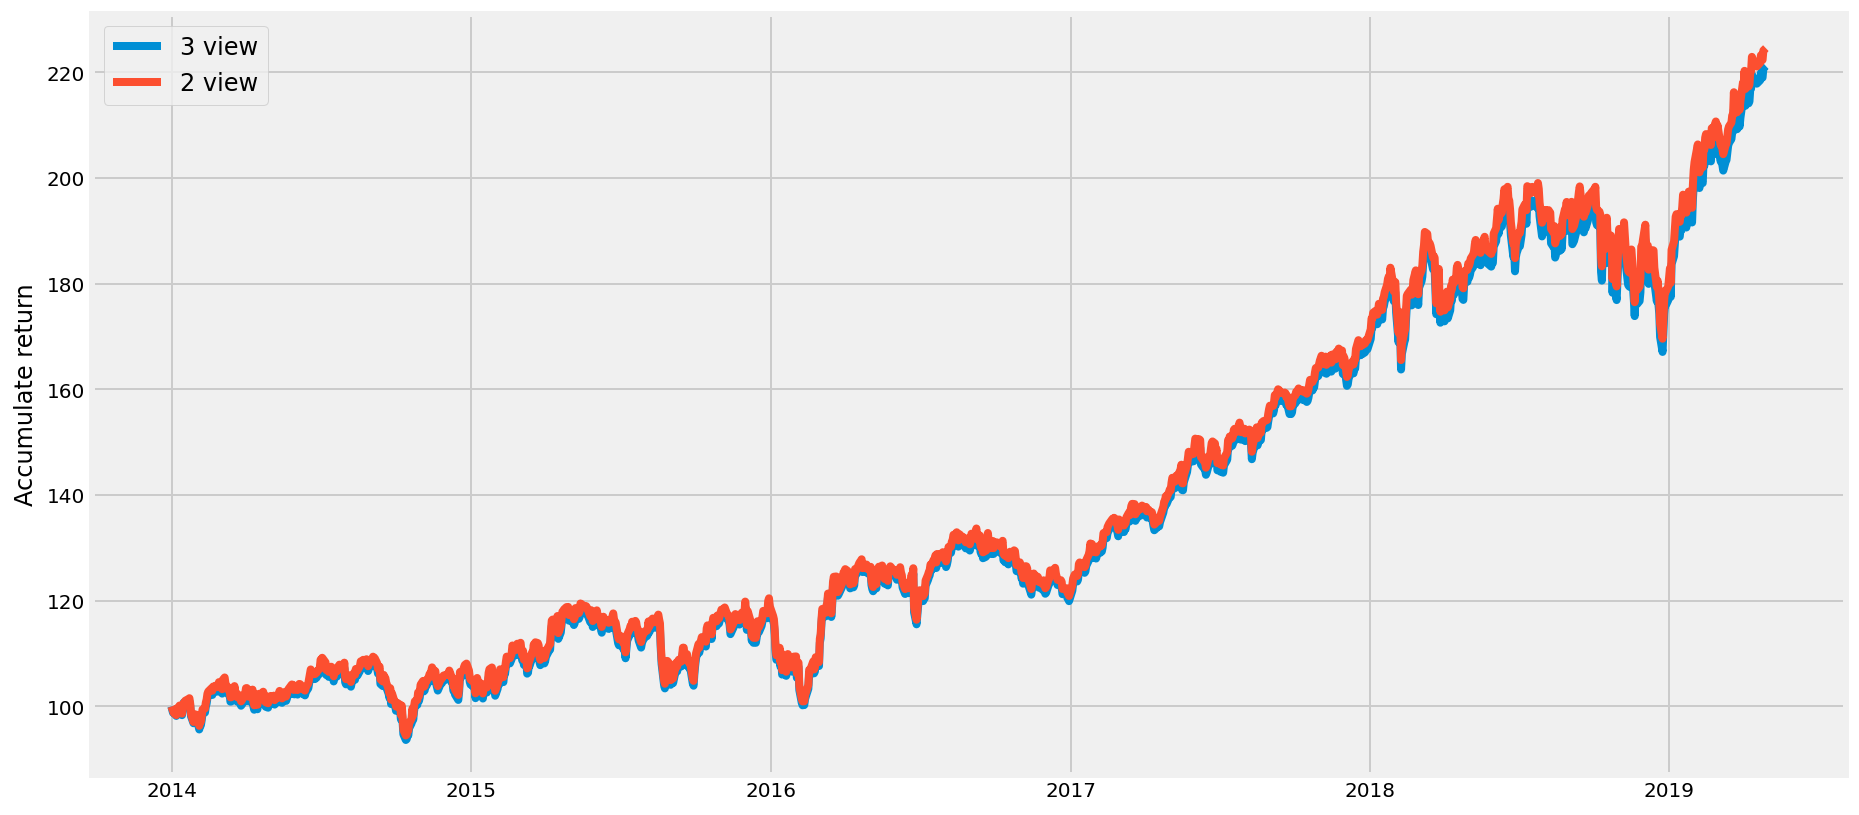

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(date,test_return,label='3 view')
plt.plot(date,test_return2,label='2 view')
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Accumulate return')

In [29]:
#Annual Return
print(math.pow(test_return[len(test_return)-1]/100,3/16))
print(math.pow(test_return2[len(test_return2)-1]/100,3/16))
#Annual Volatility
print(statistics.stdev(all_test_return)*np.sqrt(252))
print(statistics.stdev(all_test_return2)*np.sqrt(252))
#Return/ Risk
print((math.pow(test_return[len(test_return)-1]/100,3/16)-1)/(statistics.stdev(all_test_return)*np.sqrt(252)))
print((math.pow(test_return2[len(test_return2)-1]/100,3/16)-1)/(statistics.stdev(all_test_return2)*np.sqrt(252)))

1.1605262556678757
1.1638331396281558
0.16265915065305567
0.16261851600366192
0.986887334794159
1.0074691594434828


Text(0, 0.5, 'Accumulate return')

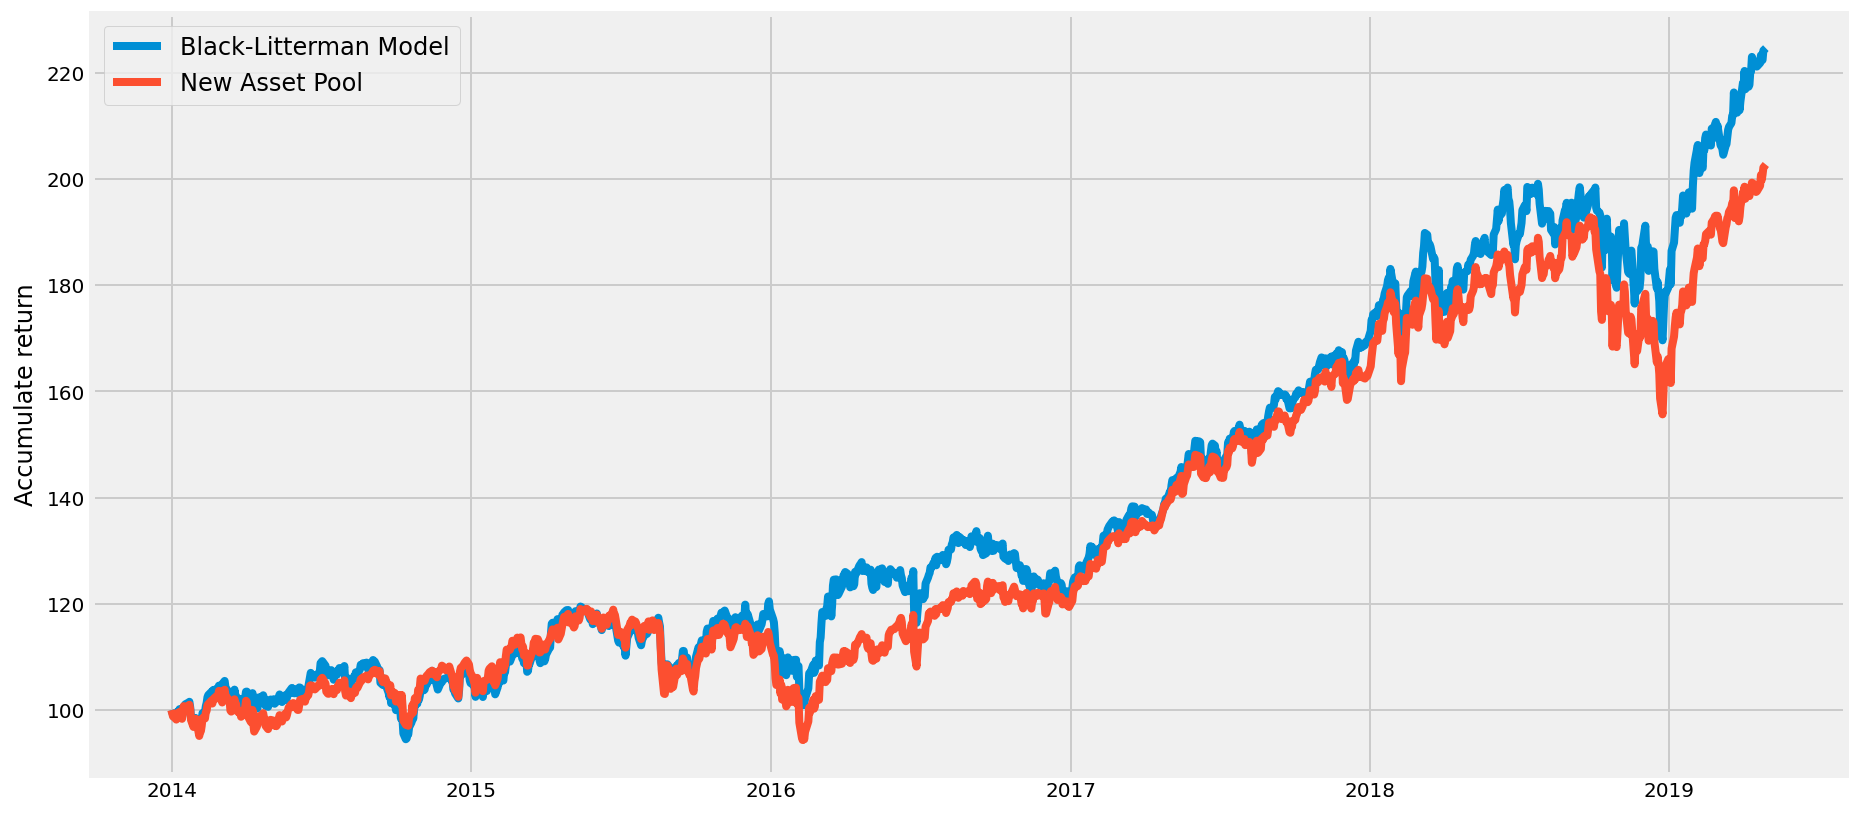

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(date,test_return2,label='Black-Litterman Model')
plt.plot(date,newAWCI_return,label='New Asset Pool')
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Accumulate return')

In [31]:
#Annual Return
print(math.pow(test_return2[len(test_return2)-1]/100,3/16))
print(math.pow(newAWCI_return[len(newAWCI_return)-1]/100,3/16))
#Annual Volatility
print(statistics.stdev(all_test_return2)*np.sqrt(252))
print(statistics.stdev(all_newAWCI_return)*np.sqrt(252))
#Return/ Risk
print((math.pow(test_return2[len(test_return2)-1]/100,3/16)-1)/(statistics.stdev(all_test_return2)*np.sqrt(252)))
print((math.pow(newAWCI_return[len(newAWCI_return)-1]/100,3/16)-1)/(statistics.stdev(all_newAWCI_return)*np.sqrt(252)))

1.1638331396281558
1.1416586751072764
0.16261851600366192
0.1604112540524881
1.0074691594434828
0.8830968621498607


Text(0, 0.5, 'Accumulate return')

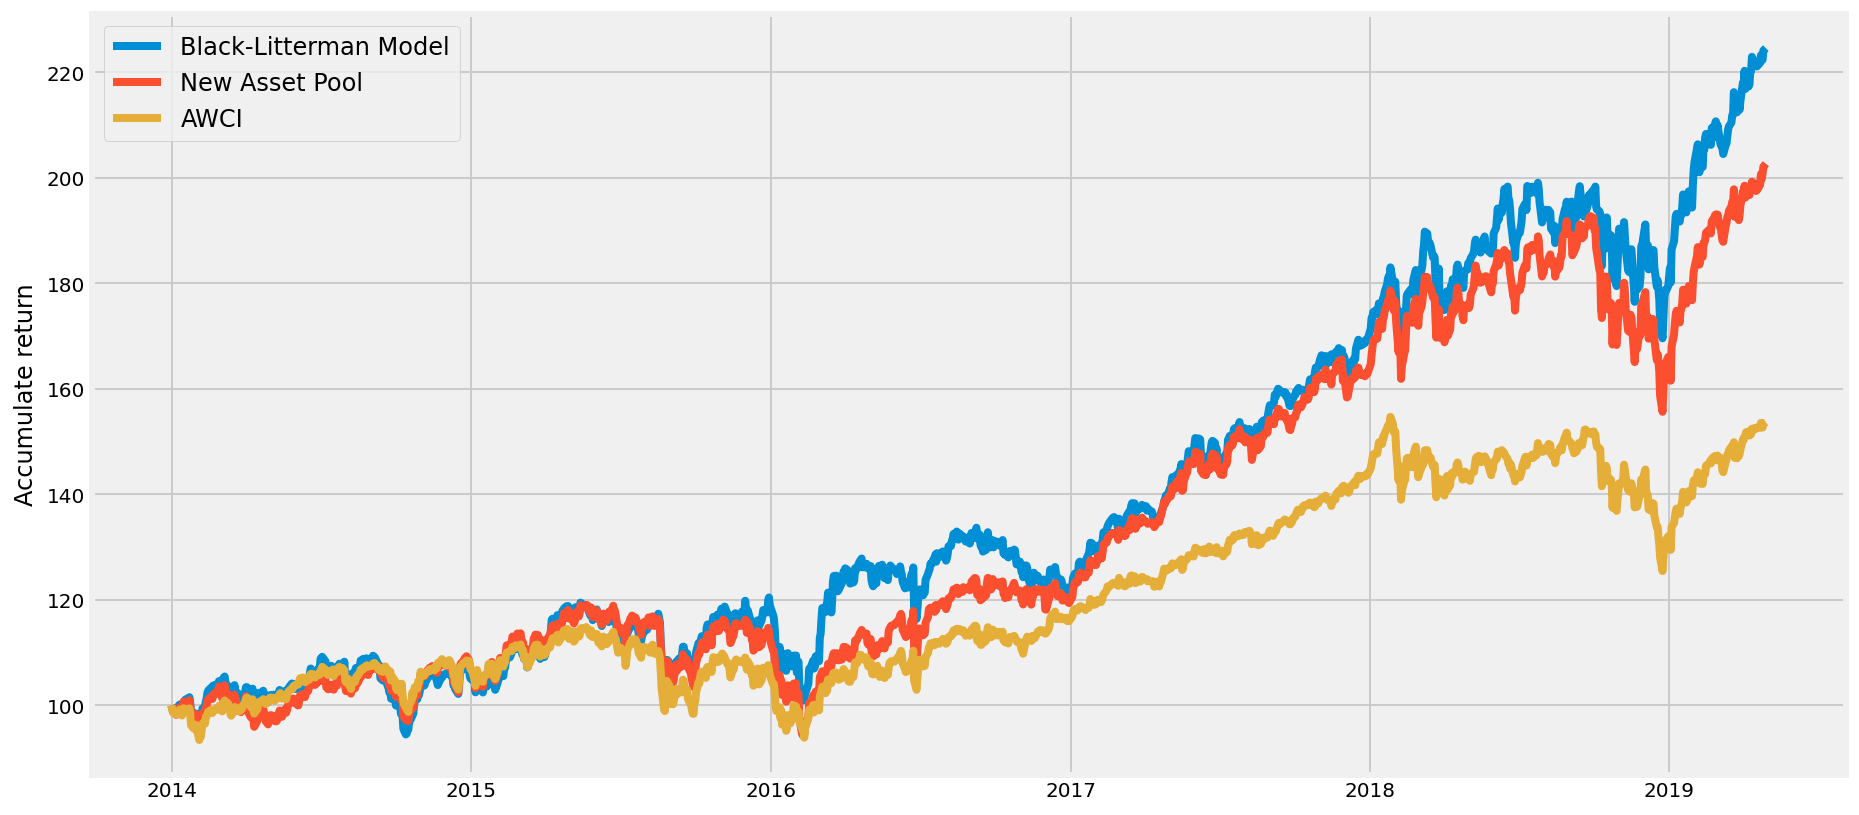

In [32]:
plt.figure(figsize=(14, 7))
plt.plot(date,test_return2,label='Black-Litterman Model')
plt.plot(date,newAWCI_return,label='New Asset Pool')
plt.plot(date,AWCI_return,label='AWCI')
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Accumulate return')

In [33]:
#Volatility Control
target_volatility = 0.13143 #AWCI's Volatility

In [34]:
#Calculate the return of new asset pool with volatility Control
i = 0 #2013/12/31
ticker = ['EWA','EWZ','EWC','FXI','EWQ','EWG','EWH','EWI','EWJ','EWY','EWN','EWS','EZA','EWP','EWD','EWL','EWT','EWU','IGV']
returns = new.pct_change()
nextRebalanceMonth = 4
date = []
newAWCI_return = []
all_newAWCI_return = []
while(i<len(new)):
    #control every Monday
    if new.index.weekday[i]==0:
        #rebalance in first Monday of each Q
        if new.index.month[i]==nextRebalanceMonth:
            if nextRebalanceMonth==10:
                nextRebalanceMonth=1
            else:
                nextRebalanceMonth=nextRebalanceMonth+3
            weights = np.array([0.01797,0.00554,0.02888,0.04935,0.02994,0.0239,0.01081,0.00598,0.0751,0.01466,0.01201,0.00316,0.00454,0.00672,0.00773,0.03099,0.0154,0.04248,0.61484])
        #volatility control
        if i>20:
            price = new[i-21:i-1].copy()
            log_returns = []
            for t in ticker:
                temp = []
                for j in range(1,len(price)):
                    temp.append(math.log(price[t][j])-math.log(price[t][j-1]))
                log_returns.append(pd.DataFrame(temp))
            log_returns = pd.concat(log_returns,axis=1)
            cov_matrix = log_returns.cov()
            std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
            if std > target_volatility:
                weights = weights*target_volatility/std
    #Calculate return everyday
    date.append(new.index[i])
    if i==0:
        newAWCI_return.append(100)
    else:
        daily_return = returns['EWA'][i]*weights[0]+returns['EWZ'][i]*weights[1]+returns['EWC'][i]*weights[2]+returns['FXI'][i]*weights[3]+returns['EWQ'][i]*weights[4]+returns['EWG'][i]*weights[5]+returns['EWH'][i]*weights[6]+returns['EWI'][i]*weights[7]+returns['EWJ'][i]*weights[8]+returns['EWY'][i]*weights[9]+returns['EWN'][i]*weights[10]+returns['EWS'][i]*weights[11]+returns['EZA'][i]*weights[12]+returns['EWP'][i]*weights[13]+returns['EWD'][i]*weights[14]+returns['EWL'][i]*weights[15]+returns['EWT'][i]*weights[16]+returns['EWU'][i]*weights[17]+returns['IGV'][i]*weights[18]
        all_newAWCI_return.append(daily_return)
        temp = newAWCI_return[i-1]*(1+daily_return)
        newAWCI_return.append(temp)
    i += 1

In [35]:
#Calculate Black-Litterman return with volatility Control (2 view)
i = 0 #2013/12/31
ticker = ['EWA','EWZ','EWC','FXI','EWQ','EWG','EWH','EWI','EWJ','EWY','EWN','EWS','EZA','EWP','EWD','EWL','EWT','EWU','IGV']
nextRebalanceMonth = 2
date = []
test_return2 = []
all_test_return2 = []
while(i<len(test)):
    #balance with view every month
    if test.index.month[i]==nextRebalanceMonth:
        if nextRebalanceMonth==12:
            nextRebalanceMonth = 1
        else:
            nextRebalanceMonth += 1
        #Reset weights to origin one
        weights = origin_weights.copy()
        #bband (%B) and Bias
        pb = [] #%B
        bias = []
        for t in ticker:
            price = test[t][i-20:i].copy().values.tolist()
            twentyMA = statistics.mean(price)
            bandwidth = statistics.stdev(price)*2
            pb.append((test[t][i]-(twentyMA-bandwidth))/(bandwidth*2))
            bias.append((test[t][i]-twentyMA)/twentyMA)
        pb = np.array(pb)
        bias = np.array(bias)
        #produce view
        sigma = returns[i-20:i].copy().cov()
        implied_excess_return = risk_aversion*np.dot(sigma, weights)
        #view 1
        P1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(pb)[-1:]: #Max 1, relative near upperband
            P1[j] = 1
        for j in np.argsort(pb)[:1]: #min 1, relative near lowerband
            P1[j] = -1
        #view 2
        P2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(bias)[-1:]: #Max 1, big chance to drop
            P2[j] = 1
        for j in np.argsort(bias)[:2]: #min 2, big chance to rise
            P2[j] = -0.5
        P = np.array([P1,P2])
        #new return, sigma and weights
        r1 = np.linalg.inv(np.linalg.inv(tau*sigma)+np.dot(np.dot(P.T,omega),P))
        r2 = np.dot(np.linalg.inv(tau*sigma),implied_excess_return)+np.dot(np.dot(P.T,omega),Q)
        r_posterior = np.dot(r1,r2)
        sigma_posterior = r1
        sigma += sigma_posterior
        weights = np.dot(np.linalg.inv(risk_aversion*sigma),r_posterior)
    #control every Monday
    if new.index.weekday[i]==0:
         #volatility control
        if i>20:
            price = new[i-21:i-1].copy()
            log_returns = []
            for t in ticker:
                temp = []
                for j in range(1,len(price)):
                    temp.append(math.log(price[t][j])-math.log(price[t][j-1]))
                log_returns.append(pd.DataFrame(temp))
            log_returns = pd.concat(log_returns,axis=1)
            cov_matrix = log_returns.cov()
            std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
            if std > target_volatility:
                weights = weights*target_volatility/std
    #Calculate return everyday
    date.append(test.index[i])
    if i==0:
        test_return2.append(100)
    else:
        daily_return = returns['EWA'][i]*weights[0]+returns['EWZ'][i]*weights[1]+returns['EWC'][i]*weights[2]+returns['FXI'][i]*weights[3]+returns['EWQ'][i]*weights[4]+returns['EWG'][i]*weights[5]+returns['EWH'][i]*weights[6]+returns['EWI'][i]*weights[7]+returns['EWJ'][i]*weights[8]+returns['EWY'][i]*weights[9]+returns['EWN'][i]*weights[10]+returns['EWS'][i]*weights[11]+returns['EZA'][i]*weights[12]+returns['EWP'][i]*weights[13]+returns['EWD'][i]*weights[14]+returns['EWL'][i]*weights[15]+returns['EWT'][i]*weights[16]+returns['EWU'][i]*weights[17]+returns['IGV'][i]*weights[18]
        all_test_return2.append(daily_return)
        temp = test_return2[i-1]*(1+daily_return)
        test_return2.append(temp)
    i += 1

Text(0, 0.5, 'Accumulate return')

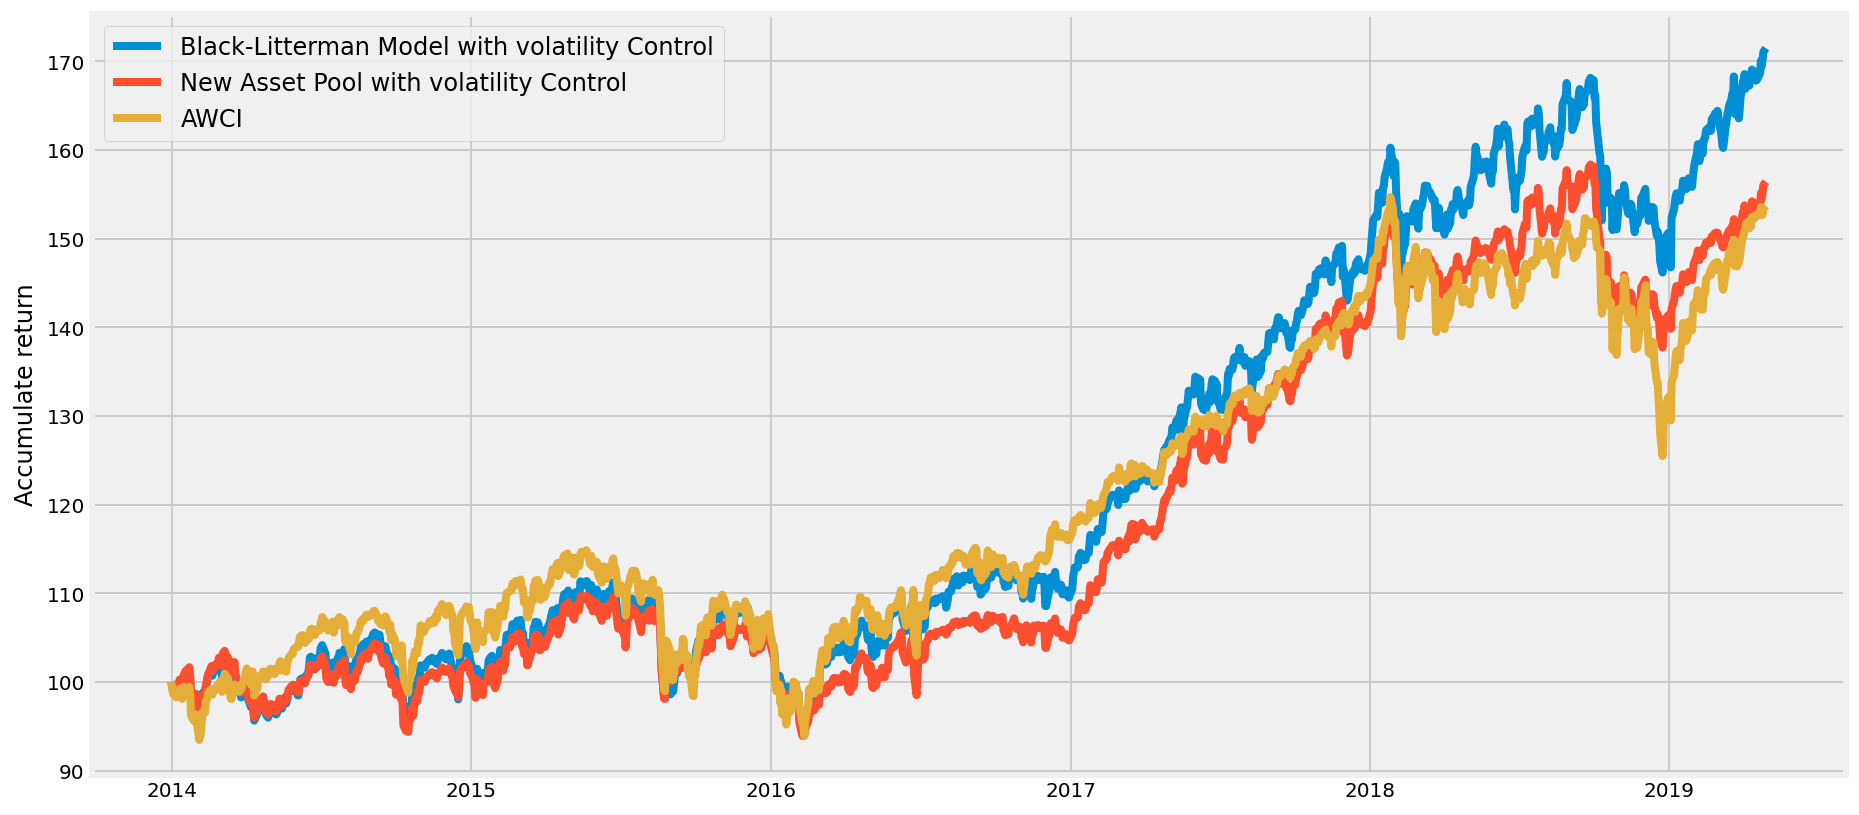

In [36]:
plt.figure(figsize=(14, 7))
plt.plot(date,test_return2,label='Black-Litterman Model with volatility Control')
plt.plot(date,newAWCI_return,label='New Asset Pool with volatility Control')
plt.plot(date,AWCI_return,label='AWCI')
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Accumulate return')

In [37]:
#Annual Return
print(math.pow(test_return2[len(test_return2)-1]/100,3/16))
print(math.pow(newAWCI_return[len(newAWCI_return)-1]/100,3/16))
print(math.pow(AWCI_return[len(AWCI_return)-1]/100,3/16))
#Annual Volatility
print(statistics.stdev(all_test_return2)*np.sqrt(252))
print(statistics.stdev(all_newAWCI_return)*np.sqrt(252))
print(statistics.stdev(all_AWCI_return)*np.sqrt(252))
#Return/ Risk
print((math.pow(test_return2[len(test_return2)-1]/100,3/16)-1)/(statistics.stdev(all_test_return2)*np.sqrt(252)))
print((math.pow(newAWCI_return[len(newAWCI_return)-1]/100,3/16)-1)/(statistics.stdev(all_newAWCI_return)*np.sqrt(252)))
print((math.pow(AWCI_return[len(AWCI_return)-1]/100,3/16)-1)/(statistics.stdev(all_AWCI_return)*np.sqrt(252)))

1.106428497822437
1.0875124616290355
1.083945339284022
0.12780397950445865
0.11512886596566238
0.1314299474248175
0.8327479178277394
0.7601261499017666
0.6387078510553432
